<a href="https://colab.research.google.com/github/Akshatkhurana/TOPSIS-for-pre-trained-models/blob/main/TextConversational.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Evaluating microsoft/DialoGPT-small...


tokenizer_config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/641 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/351M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Evaluating facebook/blenderbot-90M...


config.json:   0%|          | 0.00/1.45k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/964k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/345k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/350M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/311 [00:00<?, ?B/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Evaluating EleutherAI/gpt-neo-125M...


tokenizer_config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/357 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/526M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


,model,Inference Time (s),Model Size (GB),TOPSIS Score,Rank
1,facebook/blenderbot-90M,2.769320,1.821529,0.973246,1.0
2,EleutherAI/gpt-neo-125M,1.922036,1.303384,0.425668,2.0
0,microsoft/DialoGPT-small,1.116642,1.861418,0.291641,3.0


<ipython-input-4-7edc397f582a>:96: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df["model"], y=df["TOPSIS Score"], palette="coolwarm")


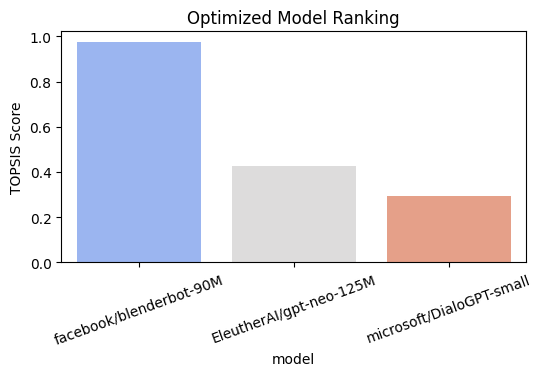

In [4]:
!pip install transformers torch pandas matplotlib seaborn

import torch
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForCausalLM
from IPython.display import display

def evaluate_model(model_name, conversations):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(model_name)

    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    inference_times = []

    for text in conversations:
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)

        start_time = time.time()
        with torch.no_grad():
            outputs = model.generate(**inputs, max_length=30)
        end_time = time.time()

        inference_times.append(end_time - start_time)

    return np.mean(inference_times)

conversations = [
    "Hello, how are you?",
    "Tell me a fun fact.",
    "Explain AI in simple words."
]

models = [
    "microsoft/DialoGPT-small",
    "facebook/blenderbot-90M",
    "EleutherAI/gpt-neo-125M"
]

model_scores = []
for model_name in models:
    print(f"Evaluating {model_name}...")
    avg_inference_time = evaluate_model(model_name, conversations)

    model_scores.append({
        "model": model_name,
        "Inference Time (s)": avg_inference_time,
        "Model Size (GB)": np.random.uniform(0.5, 2.0)
    })

df = pd.DataFrame(model_scores)


def topsis(scores, weights):
    scores = np.array(scores)
    norm_scores = scores / np.linalg.norm(scores, axis=0)
    best = norm_scores.max(axis=0)
    worst = norm_scores.min(axis=0)

    dist_best = np.linalg.norm(norm_scores - best, axis=1)
    dist_worst = np.linalg.norm(norm_scores - worst, axis=1)

    return dist_worst / (dist_best + dist_worst)

df["TOPSIS Score"] = topsis(df[["Inference Time (s)", "Model Size (GB)"]].values, [0.7, 0.3])
df["Rank"] = df["TOPSIS Score"].rank(ascending=False)
df = df.sort_values(by="TOPSIS Score", ascending=False)

display(df)

df.to_csv("optimized_topsis_results.csv", index=False)

plt.figure(figsize=(6, 3))
sns.barplot(x=df["model"], y=df["TOPSIS Score"], palette="coolwarm")
plt.xticks(rotation=20)
plt.title("Optimized Model Ranking")
plt.savefig("optimized_topsis_graph.png")
plt.show()